<a href="https://colab.research.google.com/github/rutuja-patil24/CMPE-258-Deep_Learning/blob/main/Assignment_07/Part_2_10_Custom_Optimizers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [6]:
# Step 1: Load and preprocess California Housing dataset
housing = fetch_california_housing()
X, y = housing.data, housing.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
# Step 2: Define a simple MLP model
def build_model():
    return keras.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

In [10]:
def custom_momentum_train(model, learning_rate=0.001, momentum=0.9, epochs=20, batch_size=32):
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1024).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

    loss_fn = keras.losses.MeanSquaredError()
    train_loss_history = []
    test_loss_history = []

    velocities = {id(var): tf.zeros_like(var) for var in model.trainable_variables}

    for epoch in range(epochs):
        epoch_loss = 0
        for x_batch, y_batch in train_dataset:
            with tf.GradientTape() as tape:
                predictions = model(x_batch, training=True)
                loss = loss_fn(y_batch, predictions)
            grads = tape.gradient(loss, model.trainable_variables)

            # ✅ Gradient clipping
            grads = [tf.clip_by_value(g, -1.0, 1.0) if g is not None else None for g in grads]

            for var, grad in zip(model.trainable_variables, grads):
                if grad is not None:
                    v = velocities[id(var)]
                    v = momentum * v - learning_rate * grad
                    velocities[id(var)] = v
                    var.assign_add(v)

            epoch_loss += loss.numpy()

        # Evaluate test loss
        test_loss = tf.keras.metrics.Mean()
        for x_batch, y_batch in test_dataset:
            preds = model(x_batch, training=False)
            test_loss.update_state(loss_fn(y_batch, preds))

        train_loss_history.append(epoch_loss / len(train_dataset))
        test_loss_history.append(test_loss.result().numpy())

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss_history[-1]:.4f} - Val Loss: {test_loss_history[-1]:.4f}")

    return train_loss_history, test_loss_history


In [11]:
# Step 4: Build and Train
model = build_model()
train_loss, val_loss = custom_momentum_train(model)

Epoch 1/20 - Train Loss: 0.7413 - Val Loss: 0.4770
Epoch 2/20 - Train Loss: 0.4474 - Val Loss: 0.4337
Epoch 3/20 - Train Loss: 0.4168 - Val Loss: 0.4150
Epoch 4/20 - Train Loss: 0.3951 - Val Loss: 0.3954
Epoch 5/20 - Train Loss: 0.3841 - Val Loss: 0.3858
Epoch 6/20 - Train Loss: 0.3764 - Val Loss: 0.3796
Epoch 7/20 - Train Loss: 0.3742 - Val Loss: 0.3812
Epoch 8/20 - Train Loss: 0.3553 - Val Loss: 0.3604
Epoch 9/20 - Train Loss: 0.3552 - Val Loss: 0.3531
Epoch 10/20 - Train Loss: 0.3477 - Val Loss: 0.3589
Epoch 11/20 - Train Loss: 0.3388 - Val Loss: 0.3511
Epoch 12/20 - Train Loss: 0.3640 - Val Loss: 0.3383
Epoch 13/20 - Train Loss: 0.3384 - Val Loss: 0.3414
Epoch 14/20 - Train Loss: 0.3321 - Val Loss: 0.3278
Epoch 15/20 - Train Loss: 0.3246 - Val Loss: 0.3246
Epoch 16/20 - Train Loss: 0.3187 - Val Loss: 0.3224
Epoch 17/20 - Train Loss: 0.3177 - Val Loss: 0.3251
Epoch 18/20 - Train Loss: 0.3169 - Val Loss: 0.3255
Epoch 19/20 - Train Loss: 0.3109 - Val Loss: 0.3170
Epoch 20/20 - Train L

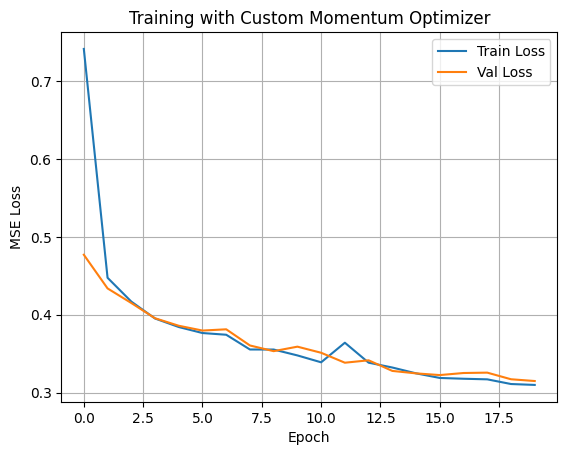

In [12]:
# Step 5: Plot Loss Curves
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title("Training with Custom Momentum Optimizer")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()
